# Time Series Tasks

## Attacks

- FGSM
- BIM
- PGD

## Regression

- ANN
- LSTM ( + BDLSTM, Peephole LSTM )
- CNN
- CNN + LSTM

## Classification

- 
- 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
if tf.config.list_logical_devices("GPU") : print("GPU detected.")
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.backend import sign

import math

In [115]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['value']=scaler.fit_transform(df['value'].values.reshape(-1,1))
    return df

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

In [164]:
def fgsm_attack(data, epsilon, loss):
    # Collect the element-wise sign of the data gradient
    data_gradient = np.gradient(loss)
    sign_data_gradient = sign(data_gradient[0])
    sign_data_gradient = np.reshape(sign_data_gradient, (1000, 23, 1))
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_data = data + epsilon*sign_data_gradient
    # Return the perturbed image
    return perturbed_data

def pgd_attack(X_test, y_test, model, iterations = 7, alpha = 2, epsilon = 8/255):
    
    gen_img = tf.convert_to_tensor(X_test, dtype=tf.float32)
    gen_img = gen_img + tf.random.uniform(gen_img.get_shape().as_list(), minval=-epsilon, maxval=epsilon, dtype=tf.dtypes.float32)
    x_temp = X_test

    for iters in range(iterations):
        imgv = tf.Variable(gen_img)
        with tf.GradientTape() as tape:
            tape.watch(imgv)
            predictions = model(imgv)
            loss = tf.keras.losses.MeanSquaredError()(y_test, predictions)
            grads = tape.gradient(loss,imgv)

        signed_grads = tf.sign(grads)
        gen_img = gen_img + (alpha*signed_grads)
        gen_img = tf.clip_by_value(gen_img, X_test-epsilon, X_test+epsilon)
        
    return gen_img
    

In [117]:
fpath='data/hourly-energy-consumption/AEP_hourly.csv'
df=pd.read_csv(fpath)
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.columns = ["value"]
display(df.head())

df_norm = normalize_data(df)
df_norm.shape

,value
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


(121273, 1)

In [118]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(0, len(stock)-seq_len, seq_len+1):
        X_train.append(stock.iloc[i: i+seq_len, 0])
        y_train.append(stock.iloc[i+seq_len, 0])
        
    #last 1000 days are going to be used in test
    X_test = X_train[4053:]             
    y_test = y_train[4053:]
    
    #first 4053 days are going to be used in training
    X_train = X_train[:4053]           
    y_train = y_train[:4053]
    
    # convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (4053, seq_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

#create train, test data
seq_len = 23 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df_norm, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (4053, 23, 1)
y_train.shape =  (4053,)
X_test.shape =  (1000, 23, 1)
y_test.shape =  (1000,)


In [194]:
# build model
lstm_model = Sequential()
lstm_model.add(LSTM(23,activation="tanh", input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.summary()

lstm_model_2 = Sequential()
lstm_model_2.add(LSTM(23,activation="tanh", input_shape=(X_train.shape[1],1), return_sequences=True))
lstm_model_2.add(Dropout(0.15))
lstm_model_2.add(LSTM(23,activation="tanh", input_shape=(X_train.shape[1],1)))
lstm_model_2.add(Dense(1))

annModel = Sequential()
annModel.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
annModel.add(Dense(1))

models = {
    "lstm_model": lstm_model,
    "lstm_model_2": lstm_model_2,
#     "annModel": annModel
    }


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 23)                2300      
                                                                 
 dropout_14 (Dropout)        (None, 23)                0         
                                                                 
 dense_28 (Dense)            (None, 1)                 24        
                                                                 
Total params: 2,324
Trainable params: 2,324
Non-trainable params: 0
_________________________________________________________________


In [171]:
model = lstm_model_2
# train LSTM model
model.compile(optimizer="adam",loss="MSE")
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
127/127 [==============================] - 2s 5ms/step - loss: 0.0322
Epoch 2/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0119
Epoch 3/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0054
Epoch 4/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0046
Epoch 5/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0038
Epoch 6/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0029
Epoch 7/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0024
Epoch 8/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0020
Epoch 9/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0017
Epoch 10/10
127/127 [==============================] - 1s 5ms/step - loss: 0.0014


In [120]:
lstm_predictions = model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",round(lstm_score,2))

R^2 Score of LSTM model =  0.95


In [121]:
lstm_predictions = lstm_predictions.reshape((lstm_predictions.shape[0]))
print("RMSE :",round(math.sqrt(mean_squared_error(y_test, lstm_predictions))*100,2))
print("MAPE :",round(mape(y_test, lstm_predictions),2))

RMSE : 2.98
MAPE : 7.06


### Adversarial Attack (FGSM)

In [122]:
adversarial = fgsm_attack(X_test, 0.1, mean_squared_error(X_test, y_test))

In [123]:
adversarial_prediction = model.predict(adversarial)
adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
adversarial_mape = round(mape(y_test, adversarial_prediction),2)
print("FGSM Adversarial R^2 : ", adversarial_score_r2)
print("FGSM Adversarial RMSE : ", adversarial_rmse)
print("FGSM Adversarial MAPE : ", adversarial_mape)

Adversarial R^2 :  0.52
Adversarial RMSE :  8.81
Adversarial MAPE :  46.59


### Results

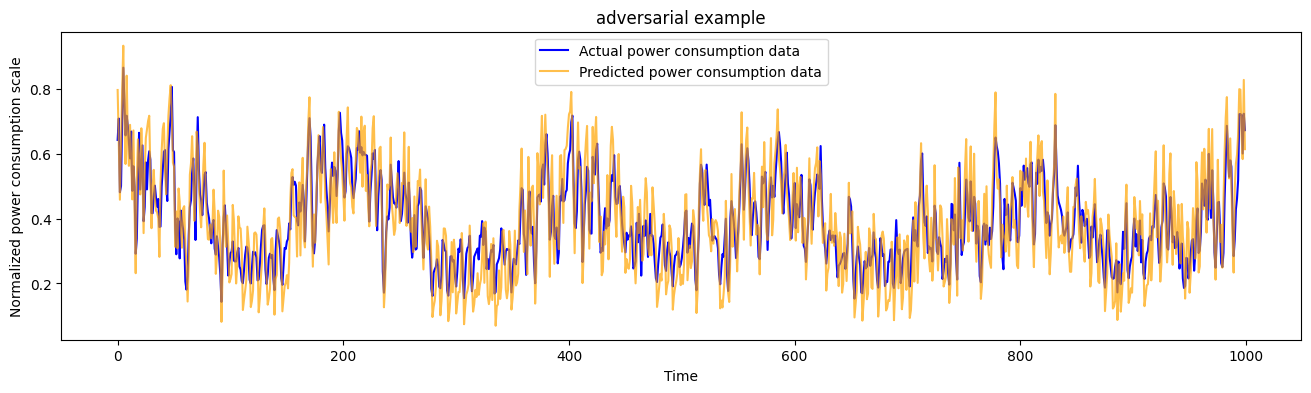

In [124]:
plot_predictions(y_test, adversarial_prediction, "adversarial example")

### Adversarial Attack (PGA)

In [165]:
adversarial = pgd_attack(X_test, y_test, model)

In [166]:
adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
adversarial_mape = round(mape(y_test, adversarial_prediction),2)
print("PGD Adversarial R^2 : ", adversarial_score_r2)
print("PGD Adversarial RMSE : ", adversarial_rmse)
print("PGD Adversarial MAPE : ", adversarial_mape)

PGD Adversarial R^2 :  0.8
PGD Adversarial RMSE :  5.76
PGD Adversarial MAPE :  48.61


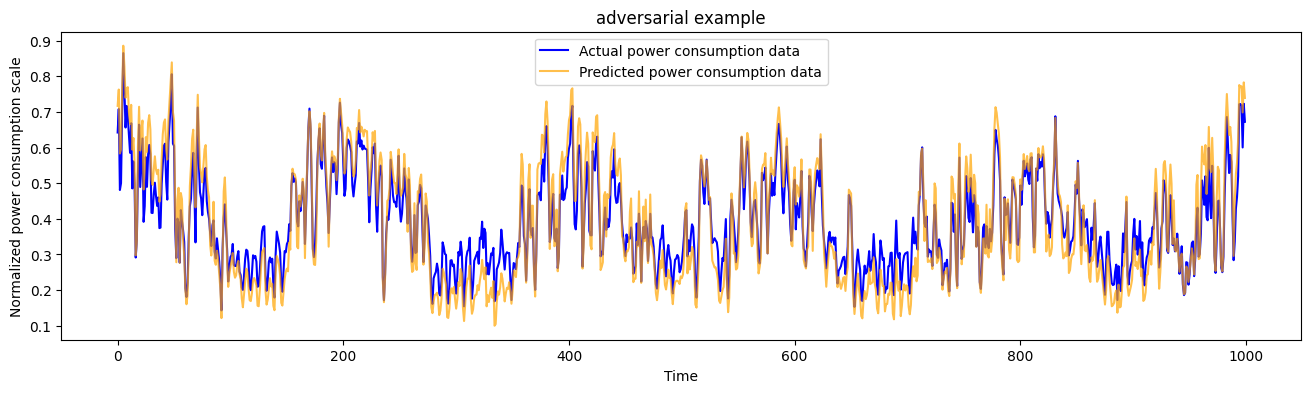

In [167]:
plot_predictions(y_test, adversarial_prediction, "adversarial example")

In [199]:
metric_df = {}
for metric in ["R2", "MAPE", "RMSE"]:
    metric_df[metric] = pd.DataFrame(index = models.keys(), columns = ["Vanilla", "FGSM", "PGD"])

In [221]:
for item in models.items():
    
    model = item[1]
    #Train
    model.compile(optimizer="adam",loss="MSE")
    model.fit(X_train, y_train, epochs=10)
    
    preds = model.predict(X_test)
    R2_score = r2_score(y_test, preds)
    print("R^2 :",round(R2_score,2))
    preds = preds.reshape((preds.shape[0]))
    print("RMSE :",round(math.sqrt(mean_squared_error(y_test, preds))*100,2))
    print("MAPE :",round(mape(y_test, preds),2))
    
    metric_df["R2"].loc[item[0], "Vanilla"] = round(R2_score,2)
    metric_df["MAPE"].loc[item[0], "Vanilla"] = round(mape(y_test, preds),2)
    metric_df["RMSE"].loc[item[0], "Vanilla"] = round(math.sqrt(mean_squared_error(y_test, preds))*100,2)
    
    #FGSM
    adversarial_fgsm = fgsm_attack(X_test, 0.1, mean_squared_error(X_test, y_test))
    adversarial_prediction = model.predict(adversarial_fgsm)
    adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
    adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
    adversarial_mape = round(mape(y_test, adversarial_prediction),2)
    print("FGSM Adversarial R^2 : ", adversarial_score_r2)
    print("FGSM Adversarial RMSE : ", adversarial_rmse)
    print("FGSM Adversarial MAPE : ", adversarial_mape)
    
    metric_df["R2"].loc[item[0], "FGSM"] = adversarial_score_r2
    metric_df["MAPE"].loc[item[0], "FGSM"] = adversarial_mape
    metric_df["RMSE"].loc[item[0], "FGSM"] = adversarial_rmse
    
    #PGD
    adversarial_pgd = pgd_attack(X_test, y_test, model, epsilon = 0.05)
    adversarial_prediction = model.predict(adversarial_pgd)
    adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
    adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
    adversarial_mape = round(mape(y_test, adversarial_prediction),2)
    print("PGD Adversarial R^2 : ", adversarial_score_r2)
    print("PGD Adversarial RMSE : ", adversarial_rmse)
    print("PGD Adversarial MAPE : ", adversarial_mape)
    
    metric_df["R2"].loc[item[0], "PGD"] = adversarial_score_r2
    metric_df["MAPE"].loc[item[0], "PGD"] = adversarial_mape
    metric_df["RMSE"].loc[item[0], "PGD"] = adversarial_rmse
    


Epoch 1/10
127/127 [==============================] - 1s 3ms/step - loss: 8.9080e-04
Epoch 2/10
127/127 [==============================] - 0s 3ms/step - loss: 9.1147e-04
Epoch 3/10
127/127 [==============================] - 0s 3ms/step - loss: 8.8412e-04
Epoch 4/10
127/127 [==============================] - 0s 3ms/step - loss: 8.4118e-04
Epoch 5/10
127/127 [==============================] - 0s 3ms/step - loss: 8.1823e-04
Epoch 6/10
127/127 [==============================] - 0s 3ms/step - loss: 8.3766e-04
Epoch 7/10
127/127 [==============================] - 0s 3ms/step - loss: 8.1096e-04
Epoch 8/10
127/127 [==============================] - 0s 3ms/step - loss: 8.4994e-04
Epoch 9/10
127/127 [==============================] - 0s 3ms/step - loss: 8.8695e-04
Epoch 10/10
127/127 [==============================] - 0s 3ms/step - loss: 8.1288e-04
R^2 : 0.98
RMSE : 1.91
MAPE : 4.84
FGSM Adversarial R^2 :  0.39
FGSM Adversarial RMSE :  9.92
FGSM Adversarial MAPE :  46.78
PGD Adversarial R^2 :  0

In [222]:
for metric in metric_df.items():
    print(metric[0])
    display(metric[1])

R2


,Vanilla,FGSM,PGD
lstm_model,0.98,0.39,0.47
lstm_model_2,0.98,0.41,0.39


MAPE


,Vanilla,FGSM,PGD
lstm_model,4.84,46.78,56.65
lstm_model_2,4.34,47.37,58.27


RMSE


,Vanilla,FGSM,PGD
lstm_model,1.91,9.92,9.32
lstm_model_2,1.74,9.8,9.98


In [210]:
from foolbox import TensorFlowModel, accuracy, samples, Model
from foolbox.attacks import LinfPGD

fmodel: Model = TensorFlowModel(model, bounds=(0, 1))
fmodel = fmodel.transform_bounds((0, 1))

clean_acc = accuracy(fmodel, X_test, y_test)
print(f"clean accuracy:  {clean_acc * 100:.1f} %")

# apply the attack
attack = LinfPGD()
epsilons = [
    0.0,
    0.0002,
    0.0005,
    0.0008,
    0.001,
    0.0015,
    0.002,
    0.003,
    0.01,
    0.1,
    0.3,
    0.5,
    1.0,
]
raw_advs, clipped_advs, success = attack(fmodel, X_test, y_test, epsilons=epsilons)

clean accuracy:  0.0 %


2022-11-23 16:36:53.975657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 16:36:53.975937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 16:36:53.976147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 16:36:53.976462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 16:36:53.976669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

NotImplementedError: 

In [216]:
from absl import app, flags
FLAGS = flags.FLAGS

from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

In [250]:
x_pgd = projected_gradient_descent(model, X_test, 0.05, 0.01, 40, np.inf)
y_pred_pgd = model(x_pgd)
y_pred_pgd = y_pred_pgd.numpy()


adversarial_score_r2 = round(r2_score(y_test, y_pred_pgd),2)
adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, y_pred_pgd.reshape(1,-1)[0]))*100,2)
adversarial_mape = round(mape(y_test, y_pred_pgd),2)
print("PGD Adversarial R^2 : ", adversarial_score_r2)
print("PGD Adversarial RMSE : ", adversarial_rmse)
print("PGD Adversarial MAPE : ", adversarial_mape)

PGD Adversarial R^2 :  0.98
PGD Adversarial RMSE :  1.74
PGD Adversarial MAPE :  40.75
